# Visual: classification
This notebook takes the next step in the [Bird's eye page view classification defined in the baselines](./Doc-Classification-Baselines.ipynb). In this experiment we take our trained CNN-based visual-backbone and train the decoders for layout type [`non-doc`,`plain-text`,`form-table`] and orientation [`N/A`,`0`,`90`,`180`,`270`] detection.
The same as with the baselines we consider the rotation being fixed (view is aligned), the difference with the baselines: we introduced `non-doc` class.

* [Dataset and dataloader](#data)
* [Model: encoder + 2 classification heads](#model)
* [Training](#train)
* [Evaluation](#eval)


In [1]:
import os
import re
import cv2
import torch
import pandas as pd
import numpy as np
import pytesseract as pts
import matplotlib as mpl

from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from pathlib import Path

from torch import nn, Tensor
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, AdamW
from torchmetrics import F1Score, Accuracy, Precision, Recall, ConfusionMatrix
from torchsummary import summary
#from tqdm import tqdm
from time import time

In [2]:
# local lib
from scripts.dataset import SimpleLayoutDataset
from scripts.backbone import Encoder, CNNEncoder, TransformerEncoder, MeanReduce
from scripts.baselines import *

In [3]:
#torch._dynamo.config.verbose = True
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


In [4]:
# images with semantic segmentation masks available
images = [str(x).replace('/masks/','/images/') for x in Path(f'{ROOT}/data/masks').glob('*.png')]
len(images)

8768

In [5]:
VIEW_SIZE = 128
LATENT_DIM = 512

<a name="data"></a>

### Dataset and dataloader
We use the [data generated for the baselines](./Doc-Classification-Baselines.ipynb#data) -- random noisy variations of the original page-images with the rotation fixed by our prospective pipeline which may have some residual skew.

In [6]:
save_path = './data/layout-baseline'

In [7]:
samples = images

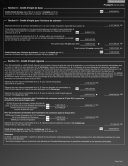

In [8]:
# see sample
Image.open(np.random.choice([str(x) for x in Path(f'./data/layout-baseline').glob('*.png')]))

In [9]:
test_samples = list(np.random.choice(samples, int(len(samples) * 0.05), replace=False))
training_samples = list(set(samples).difference(set(test_samples)))
print(f'training: {len(training_samples)}  validation: {len(test_samples)}')

training: 8330  validation: 438


<a name="labels"></a>

#### Explore labels

In [10]:
labels = pd.read_csv(f'{save_path}/labels.csv.gz')
print(f'Generated samples: {len(labels)}')
labels.groupby('orientation').size()

Generated samples: 43761


orientation
0      11033
90     10809
180    10913
270    11006
dtype: int64

In [11]:
labels = set_layout_labels(test_samples)
labels.groupby('test').size()

test
0    41575
1     2186
dtype: int64

In [12]:
nondocs_fracthion = 0.3

train_dataset = SimpleLayoutDataset(VIEW_SIZE, labels[labels['test']==0], nondocs_fracthion=nondocs_fracthion)
test_dataset  = SimpleLayoutDataset(VIEW_SIZE, labels[labels['test']==1], nondocs_fracthion=nondocs_fracthion)

Batch: torch.Size([4, 1, 128, 128]) torch.Size([]) torch.Size([])


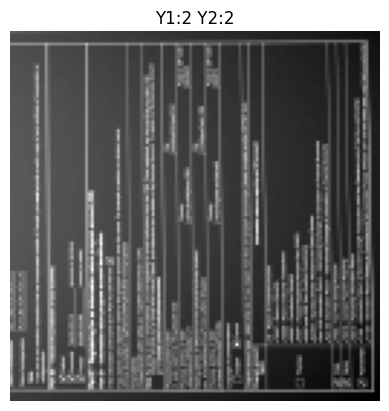

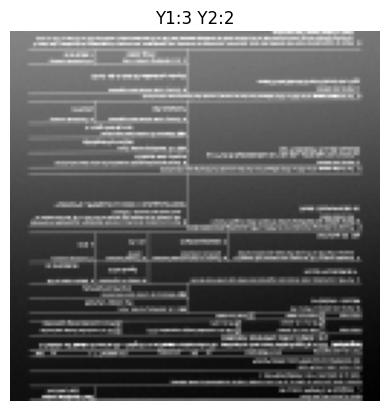

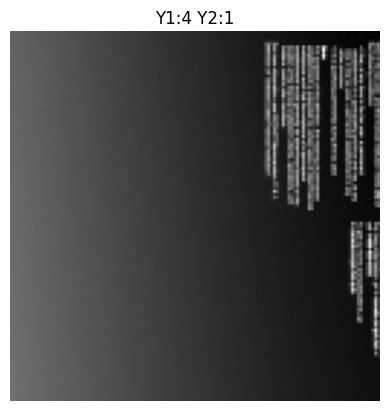

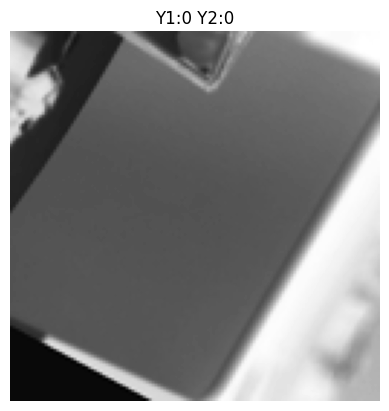

In [13]:
for X, (Y1, Y2) in DataLoader(test_dataset,  batch_size=4, shuffle=True):
    print('Batch:', X.shape, Y1[0].shape, Y2[0].shape)
    for i in range(len(X)):
        image = X[i,:].squeeze()
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(image, 'gray')
        ax.set_title(f'Y1:{Y1[i].item()} Y2:{Y2[i].item()}')
        ax.axis('off')
        plt.show()
    break

<a name="model"></a>
<h3>Model</h3>

In [14]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, num_classes, activation=None):
        layers = [nn.LayerNorm(emb_size),
                  nn.ReLU(),
                  nn.Linear(emb_size, num_classes)]
        if activation:
            layers.append(activation)
        super(ClassificationHead, self).__init__(*layers)


In [15]:
class LayoutBaseline(nn.Module):
    def __init__(self, encoder):
        super(LayoutBaseline, self).__init__()
        self.encoder = encoder
        self.orientation = ClassificationHead(LATENT_DIM, 5, nn.Softmax(dim=1))
        self.layout = ClassificationHead(LATENT_DIM, 3, nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.orientation(x), self.layout(x)


In [16]:
backbone = CNNEncoder(out_channels=64, depth=4, residual=True)
backbone.load_state_dict(torch.load('./models/visual-encoder-CNN-64-4.pt'))
encoder = Encoder(backbone, nn.AdaptiveAvgPool2d((1, 1)), frozen=False)

In [17]:
model = LayoutBaseline(encoder).to(DEVICE)
#inputs = torch.randn((16, 1, VIEW_SIZE, VIEW_SIZE)).to(DEVICE)
#model(inputs)

<a name="train"></a>

### Run training
#### 1. Define optimization

In [18]:
# orientation class-weights
W1 = 1 - np.array([nondocs_fracthion] + list(np.ones(4) * 0.25 * (1 - nondocs_fracthion)))
print(W1/sum(W1))

# layout class-weights
W2 = (labels.groupby('test').size()/len(labels)).values
W2 = 1 - np.array([nondocs_fracthion] + list(W2 * (1 - nondocs_fracthion)))
print(W2/sum(W2))

criteria = [ nn.CrossEntropyLoss(weight=torch.tensor(W1/sum(W1), dtype=torch.float32)).to(DEVICE),
             nn.CrossEntropyLoss(weight=torch.tensor(W2/sum(W2), dtype=torch.float32)).to(DEVICE) ]

[0.175   0.20625 0.20625 0.20625 0.20625]
[0.35      0.1674836 0.4825164]


In [19]:
criterion = HydraLoss(criteria).to(DEVICE)
# optimize both: model and loss parameters
params = [p for p in model.parameters()] + [p for p in criterion.parameters()]

In [20]:
learning_rate = 1e-6
optimizer = AdamW(params, lr=learning_rate)

#### 2. Define evaluation metrics

In [21]:
metrics = {
    'orientation': {
        'confmat': ConfusionMatrix(task='multiclass', num_classes=5).to(DEVICE),
        'precision': Precision(task='multiclass', average='macro', num_classes=5).to(DEVICE),
        'recall': Recall(task='multiclass', average='macro', num_classes=5).to(DEVICE),
        'accuracy': Accuracy(task='multiclass', num_classes=5).to(DEVICE) },
    'layout': {
        'confmat': ConfusionMatrix(task='multiclass', num_classes=3).to(DEVICE),
        'precision': Precision(task='multiclass', average='macro', num_classes=3).to(DEVICE),
        'recall': Recall(task='multiclass', average='macro', num_classes=3).to(DEVICE),
        'accuracy': Accuracy(task='multiclass', num_classes=3).to(DEVICE) }}


#### 4. Run training

In [22]:
batch_size = 128
# generate new data:
num_data_updates = 1
# epochs with the same data
num_epochs = num_variations * 3

In [23]:
#!rm -rf ./runs/visual-classification-cnn
trainer = Trainer(model, criterion, optimizer, metrics, multi_y=True,
                  tensorboard_dir='runs/visual-classification-cnn') # log progress to tensorboard)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size//2, shuffle=False)

results = trainer.run(train_dataloader, test_dataloader, num_epochs=num_epochs)

		Epoch: 1
Training:   100.00%:  loss: 1.7481
Validation: 100.00%:  loss: 1.5814
		Epoch: 2
Training:   100.00%:  loss: 1.5620
Validation: 100.00%:  loss: 1.5476
		Epoch: 3
Training:   100.00%:  loss: 1.5360
Validation: 100.00%:  loss: 1.5281
		Epoch: 4
Training:   100.00%:  loss: 1.5223
Validation: 100.00%:  loss: 1.5210
		Epoch: 5
Training:   100.00%:  loss: 1.5133
Validation: 100.00%:  loss: 1.5087
		Epoch: 6
Training:   100.00%:  loss: 1.5055
Validation: 100.00%:  loss: 1.5099
		Epoch: 7
Training:   100.00%:  loss: 1.4986
Validation: 100.00%:  loss: 1.5051
		Epoch: 8
Training:   100.00%:  loss: 1.4955
Validation: 100.00%:  loss: 1.4929
		Epoch: 9
Training:   100.00%:  loss: 1.4896
Validation: 100.00%:  loss: 1.4913
		Epoch: 10
Training:   100.00%:  loss: 1.4855
Validation: 100.00%:  loss: 1.4892


<a name="eval"></a>

#### 5. Show evaluation results

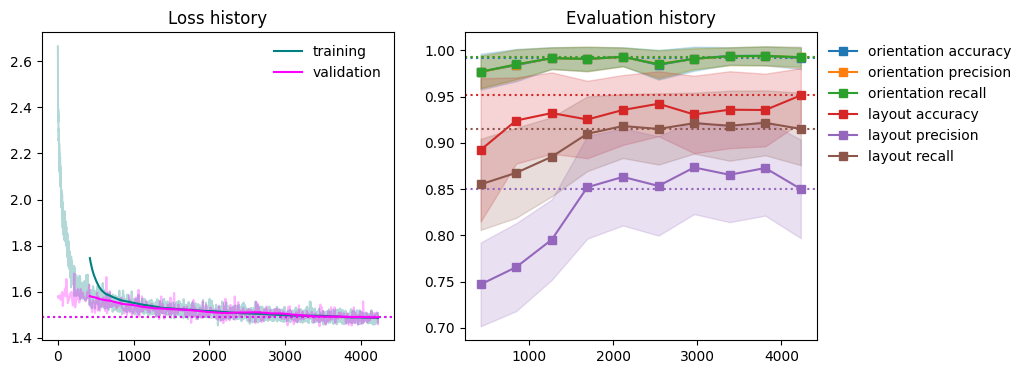

In [24]:
plot_history(trainer.loss_history, trainer.metrics_history, multi_y=True)

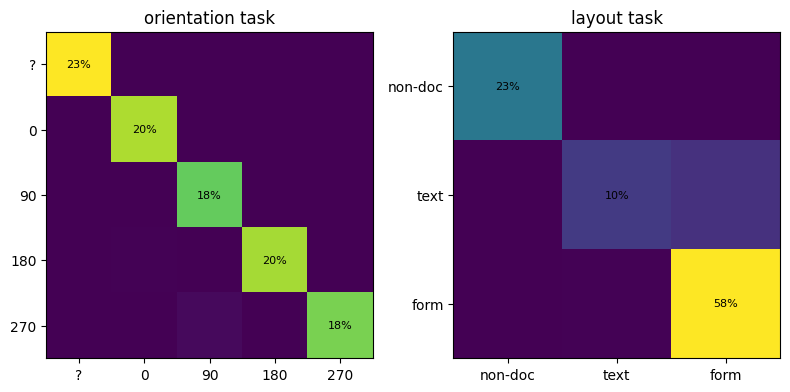

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
plot_confmat(np.array(results['orientation']['confmat']).sum(axis=0), ['?','0','90','180','270'], ax[0])
ax[0].set_title(f'orientation task')
plot_confmat(np.array(results['layout']['confmat']).sum(axis=0), ['non-doc','text','form'], ax[1])
ax[1].set_title(f'layout task')
plt.tight_layout()

    trainer.writer.close()
    torch.save(model.state_dict(), f'./models/classification-CNN.pt')